<a href="https://colab.research.google.com/github/shiyxg/KAUST_log/blob/master/Yolo_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection By Yolo Method

In this Lab, We are going to train a Network to do Object Detection


## Preparations

Before run the following code blocks, Please prepare your python envs:

* **Use Tensorflow 1.x**. The default tensorflow version is 2.2 and our code works on 1.x. 
* **Download Pre-trained Weights**. The network of Yolo has 23 convolutional layers, in which 22 convolutional layers are pretrained.
* **Download Necessary Functions and Datasets From Github**. In this lab, we are going to apply Yolo on 2 project: detect blood cells and license plate.

### Use Tensorflow 1.x

---

Run the following cell, And then restart the host to refresh tensorflow version.

In [ ]:
% tensorflow_version 1.x
import tensorflow as tf
version = tf.__version__
if version[0:2] == '2.':
    print('fail to use 1.x tensorflow, some unpredicted errors will occurs')
else:
    print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


### Download Pre-trained Weights.

---

Weight file is `yolov2.weights`, I have shared it to everyone by email and google drive.

* **Method 1: Upload it to our work folder.** Our work folder is `/content/`, you can upload the local file to this folder. But it will be removed if you restart the notebook. Also, make sure you have a high speed to connect colab.
* **Method 2: Download from Website.** Run `! wget https://pjreddie.com/media/files/yolov2.weights`, but the speed is only 128KB.
* **Method 3: mount your google drive**: Upload the weight to your google drive and copy it to the folder when you run the notebook. But you have to restart the notebook to mount the drive.

In [ ]:
# Method 1
# upload your local file by files/upload
# Method 2
#! wget https://pjreddie.com/media/files/yolov2.weights

# Method 3
from google.colab import drive
drive.mount('/drive')
! cp drive/My\ Drive/yolov2.weights ./


Mounted at /drive
cp: cannot stat 'drive/My Drive/yolov2.weights': Transport endpoint is not connected


### Download Necessary Functions and Datasets From Github

---

We have two datasets, One is blood cells object detection and another is license plate. For more dataset, go [Here](https://github.com/experiencor/keras-yolo3)

Dataset | mAP | Demo | Config | Model
:---:|:---:|:---:|:---:|:---:
Kangaroo Detection (1 class) (https://github.com/experiencor/kangaroo) | 95% | https://youtu.be/URO3UDHvoLY | check zoo | https://bit.ly/39rLNoE
License Plate Detection (European in Romania) (1 class) (https://github.com/RobertLucian/license-plate-dataset) | 90% | https://youtu.be/HrqzIXFVCRo | check zoo | https://bit.ly/2tIpvPl
Raccoon Detection (1 class) (https://github.com/experiencor/raccoon_dataset) | 98% | https://youtu.be/lxLyLIL7OsU | check zoo | https://bit.ly/39rLNoE
Red Blood Cell Detection (3 classes) (https://github.com/experiencor/BCCD_Dataset) | 84% | https://imgur.com/a/uJl2lRI | check zoo | https://bit.ly/39rLNoE
VOC (20 classes) (http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) | 72% | https://youtu.be/0RmOI6hcfBI | check zoo | https://bit.ly/39rLNoE


In [ ]:
! pwd
! git clone https://github.com/experiencor/keras-yolo2.git
# first script, we need to use some functions inside
! mv keras-yolo2/preprocessing.py ./
# second script
! mv keras-yolo2/utils.py ./
# blood images
! git clone https://github.com/Shenggan/BCCD_Dataset.git
# license plate dataset
#! git clone https://github.com/RobertLucian/license-plate-dataset.git


/content
Cloning into 'keras-yolo2'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 330 (delta 1), reused 1 (delta 0), pack-reused 324
Receiving objects: 100% (330/330), 53.90 MiB | 42.99 MiB/s, done.
Resolving deltas: 100% (180/180), done.
Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (378/378), done.


## Import Python Packages

---


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes
import keras

print("Keras version used: ", keras.__version__)
print("GPU imformation:", tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
print(tf.__version__)
device_lib.list_local_devices()


Using TensorFlow backend.


Keras version used:  2.3.1
GPU imformation: 
1.15.2


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5506742631698229096, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17644804119767115869
 physical_device_desc: "device: XLA_CPU device"]

## Define Configuration

---

In [ ]:
wt_path = 'yolov2.weights'  
# BCCD dataset                     
train_image_folder = 'BCCD_Dataset/BCCD/JPEGImages/'
train_annot_folder = 'BCCD_Dataset/BCCD/Annotations/'
valid_image_folder = 'BCCD_Dataset/BCCD/JPEGImages/'
valid_annot_folder = 'BCCD_Dataset/BCCD/Annotations/'
# license plate dataset
# train_image_folder = '/content/license-plate-dataset/dataset/train/images/'
# train_annot_folder = '/content/license-plate-dataset/dataset/train/annots/'
# valid_image_folder = '/content/license-plate-dataset/dataset/valid/images/'
# valid_annot_folder = '/content/license-plate-dataset/dataset/valid/annots/'

In [ ]:
# Blood Cells
LABELS = ["RBC",'WBC','Platelets']

# license plate dataset
# LABELS = ['license-plate']

# Image size
IMAGE_H, IMAGE_W = 416, 416
# Grid number in feature map, also the grids of Yolo
GRID_H,  GRID_W  = 13 , 13

# Class number and weights
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

# How many boxes proposed for each grid
BOX              = 5
# size of the 5 boxex
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

# Threshold for object
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

# parameters for training
BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50 # pass all ture boxes of a image for non-object loss function 

NameError: ignored

## Create CNN Model

In [ ]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

In [ ]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
# This layer will generate 5 boxes for each grid, and we have 13x13 grids
# each box will predict an object with W, H and center coordinate(X, Y), and also Class
# so for each box, network will give we a vector [W, H, X, Y, No_object, is_class1, is_class2, is_classn]
# In the end, the output shape of the yolo network should be [13, 13, 5, 4+1+NUM_class]
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________

## Load Pre-trained Weights

---

In [ ]:
# load weights for all layers
weight_reader = WeightReader(wt_path)
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):

    conv_layer = model.get_layer('conv_' + str(i))
    print('load weight of conv_{}'.format(i))
    # weights in BN
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
    # weights in convolutions
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

# Randomize weights of the last layer
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])



FileNotFoundError: ignored

---
## Define Loss function


![Loss](https://render.githubusercontent.com/render/math?math=%5Cbegin%7Bmultline%7D%0A%5Clambda_%5Ctextbf%7Bcoord%7D%0A%5Csum_%7Bi%20%3D%200%7D%5E%7BS%5E2%7D%0A%20%20%20%20%5Csum_%7Bj%20%3D%200%7D%5E%7BB%7D%0A%20%20%20%20%20L_%7Bij%7D%5E%7B%5Ctext%7Bobj%7D%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%5Cleft%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%5Cleft%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20x_i%20-%20%5Chat%7Bx%7D_i%0A%20%20%20%20%20%20%20%20%20%20%20%20%5Cright%29%5E2%20%2B%0A%20%20%20%20%20%20%20%20%20%20%20%20%5Cleft%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20y_i%20-%20%5Chat%7By%7D_i%0A%20%20%20%20%20%20%20%20%20%20%20%20%5Cright%29%5E2%0A%20%20%20%20%20%20%20%20%20%20%20%20%5Cright%5D%0A%5C%5C%0A%2B%20%5Clambda_%5Ctextbf%7Bcoord%7D%20%0A%5Csum_%7Bi%20%3D%200%7D%5E%7BS%5E2%7D%0A%20%20%20%20%5Csum_%7Bj%20%3D%200%7D%5E%7BB%7D%0A%20%20%20%20%20%20%20%20%20L_%7Bij%7D%5E%7B%5Ctext%7Bobj%7D%7D%0A%20%20%20%20%20%20%20%20%20%5Cleft%5B%0A%20%20%20%20%20%20%20%20%5Cleft%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%5Csqrt%7Bw_i%7D%20-%20%5Csqrt%7B%5Chat%7Bw%7D_i%7D%0A%20%20%20%20%20%20%20%20%5Cright%29%5E2%20%2B%0A%20%20%20%20%20%20%20%20%5Cleft%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%5Csqrt%7Bh_i%7D%20-%20%5Csqrt%7B%5Chat%7Bh%7D_i%7D%0A%20%20%20%20%20%20%20%20%5Cright%29%5E2%0A%20%20%20%20%20%20%20%20%5Cright%5D%0A%5C%5C%0A%2B%20%5Csum_%7Bi%20%3D%200%7D%5E%7BS%5E2%7D%0A%20%20%20%20%5Csum_%7Bj%20%3D%200%7D%5E%7BB%7D%0A%20%20%20%20%20%20%20%20L_%7Bij%7D%5E%7B%5Ctext%7Bobj%7D%7D%0A%20%20%20%20%20%20%20%20%5Cleft%28%0A%20%20%20%20%20%20%20%20%20%20%20%20C_i%20-%20%5Chat%7BC%7D_i%0A%20%20%20%20%20%20%20%20%5Cright%29%5E2%0A%5C%5C%0A%2B%20%5Clambda_%5Ctextrm%7Bnoobj%7D%0A%5Csum_%7Bi%20%3D%200%7D%5E%7BS%5E2%7D%0A%20%20%20%20%5Csum_%7Bj%20%3D%200%7D%5E%7BB%7D%0A%20%20%20%20L_%7Bij%7D%5E%7B%5Ctext%7Bnoobj%7D%7D%0A%20%20%20%20%20%20%20%20%5Cleft%28%0A%20%20%20%20%20%20%20%20%20%20%20%20C_i%20-%20%5Chat%7BC%7D_i%0A%20%20%20%20%20%20%20%20%5Cright%29%5E2%0A%5C%5C%0A%2B%20%5Csum_%7Bi%20%3D%200%7D%5E%7BS%5E2%7D%0AL_i%5E%7B%5Ctext%7Bobj%7D%7D%0A%20%20%20%20%5Csum_%7Bc%20%5Cin%20%5Ctextrm%7Bclasses%7D%7D%0A%20%20%20%20%20%20%20%20%5Cleft%28%0A%20%20%20%20%20%20%20%20%20%20%20%20p_i%28c%29%20-%20%5Chat%7Bp%7D_i%28c%29%0A%20%20%20%20%20%20%20%20%5Cright%29%5E2%0A%5Cend%7Bmultline%7D&mode=display)

Where:

* $s^2$ is number of grids in last features map
* $B$ is the number of boxex for each grid
* $C$ is the confidence about whether there is an object in a box
* $p(c)$ is the possibility of being a object of a class.
* $\lambda_?$ is the weight of an item
* $L_{i,j}^{obj/noobj}$ is mask(obj/noobj) of the grid i and box j. And $L^{obj}\cup L^{nonobj} \not= U_{all\ box}$ 

---

There are serval tricks for the loss function:
* **Warm-Up Stage:** When train-batch-num is smaller than a value, the true X&Y of a box **without any objects** should be set as the center of this box; the true W&H of it should be set as the W&H of this box.
* **No-Object box, {Best_IOU<0.6}&&{$\hat{C}$==0}:** If the IOU of a predicted box with any true boxes is smaller than 0.6, it will be considered as a no-object box. (**fourth item in loss function**).
* **Object box,  {$\hat{C}==0$}**, only the proposed full box(anchor), which has both same center point coordinate and biggest IOU with a manually labeled box, is labeled as $\hat{C}==0$
* **Negelected box, {Best_IOU>=0.6}&&{$\hat{C}$==0}**. This kind of boxes does not occur in our loss function, because usually it is not the best choice.

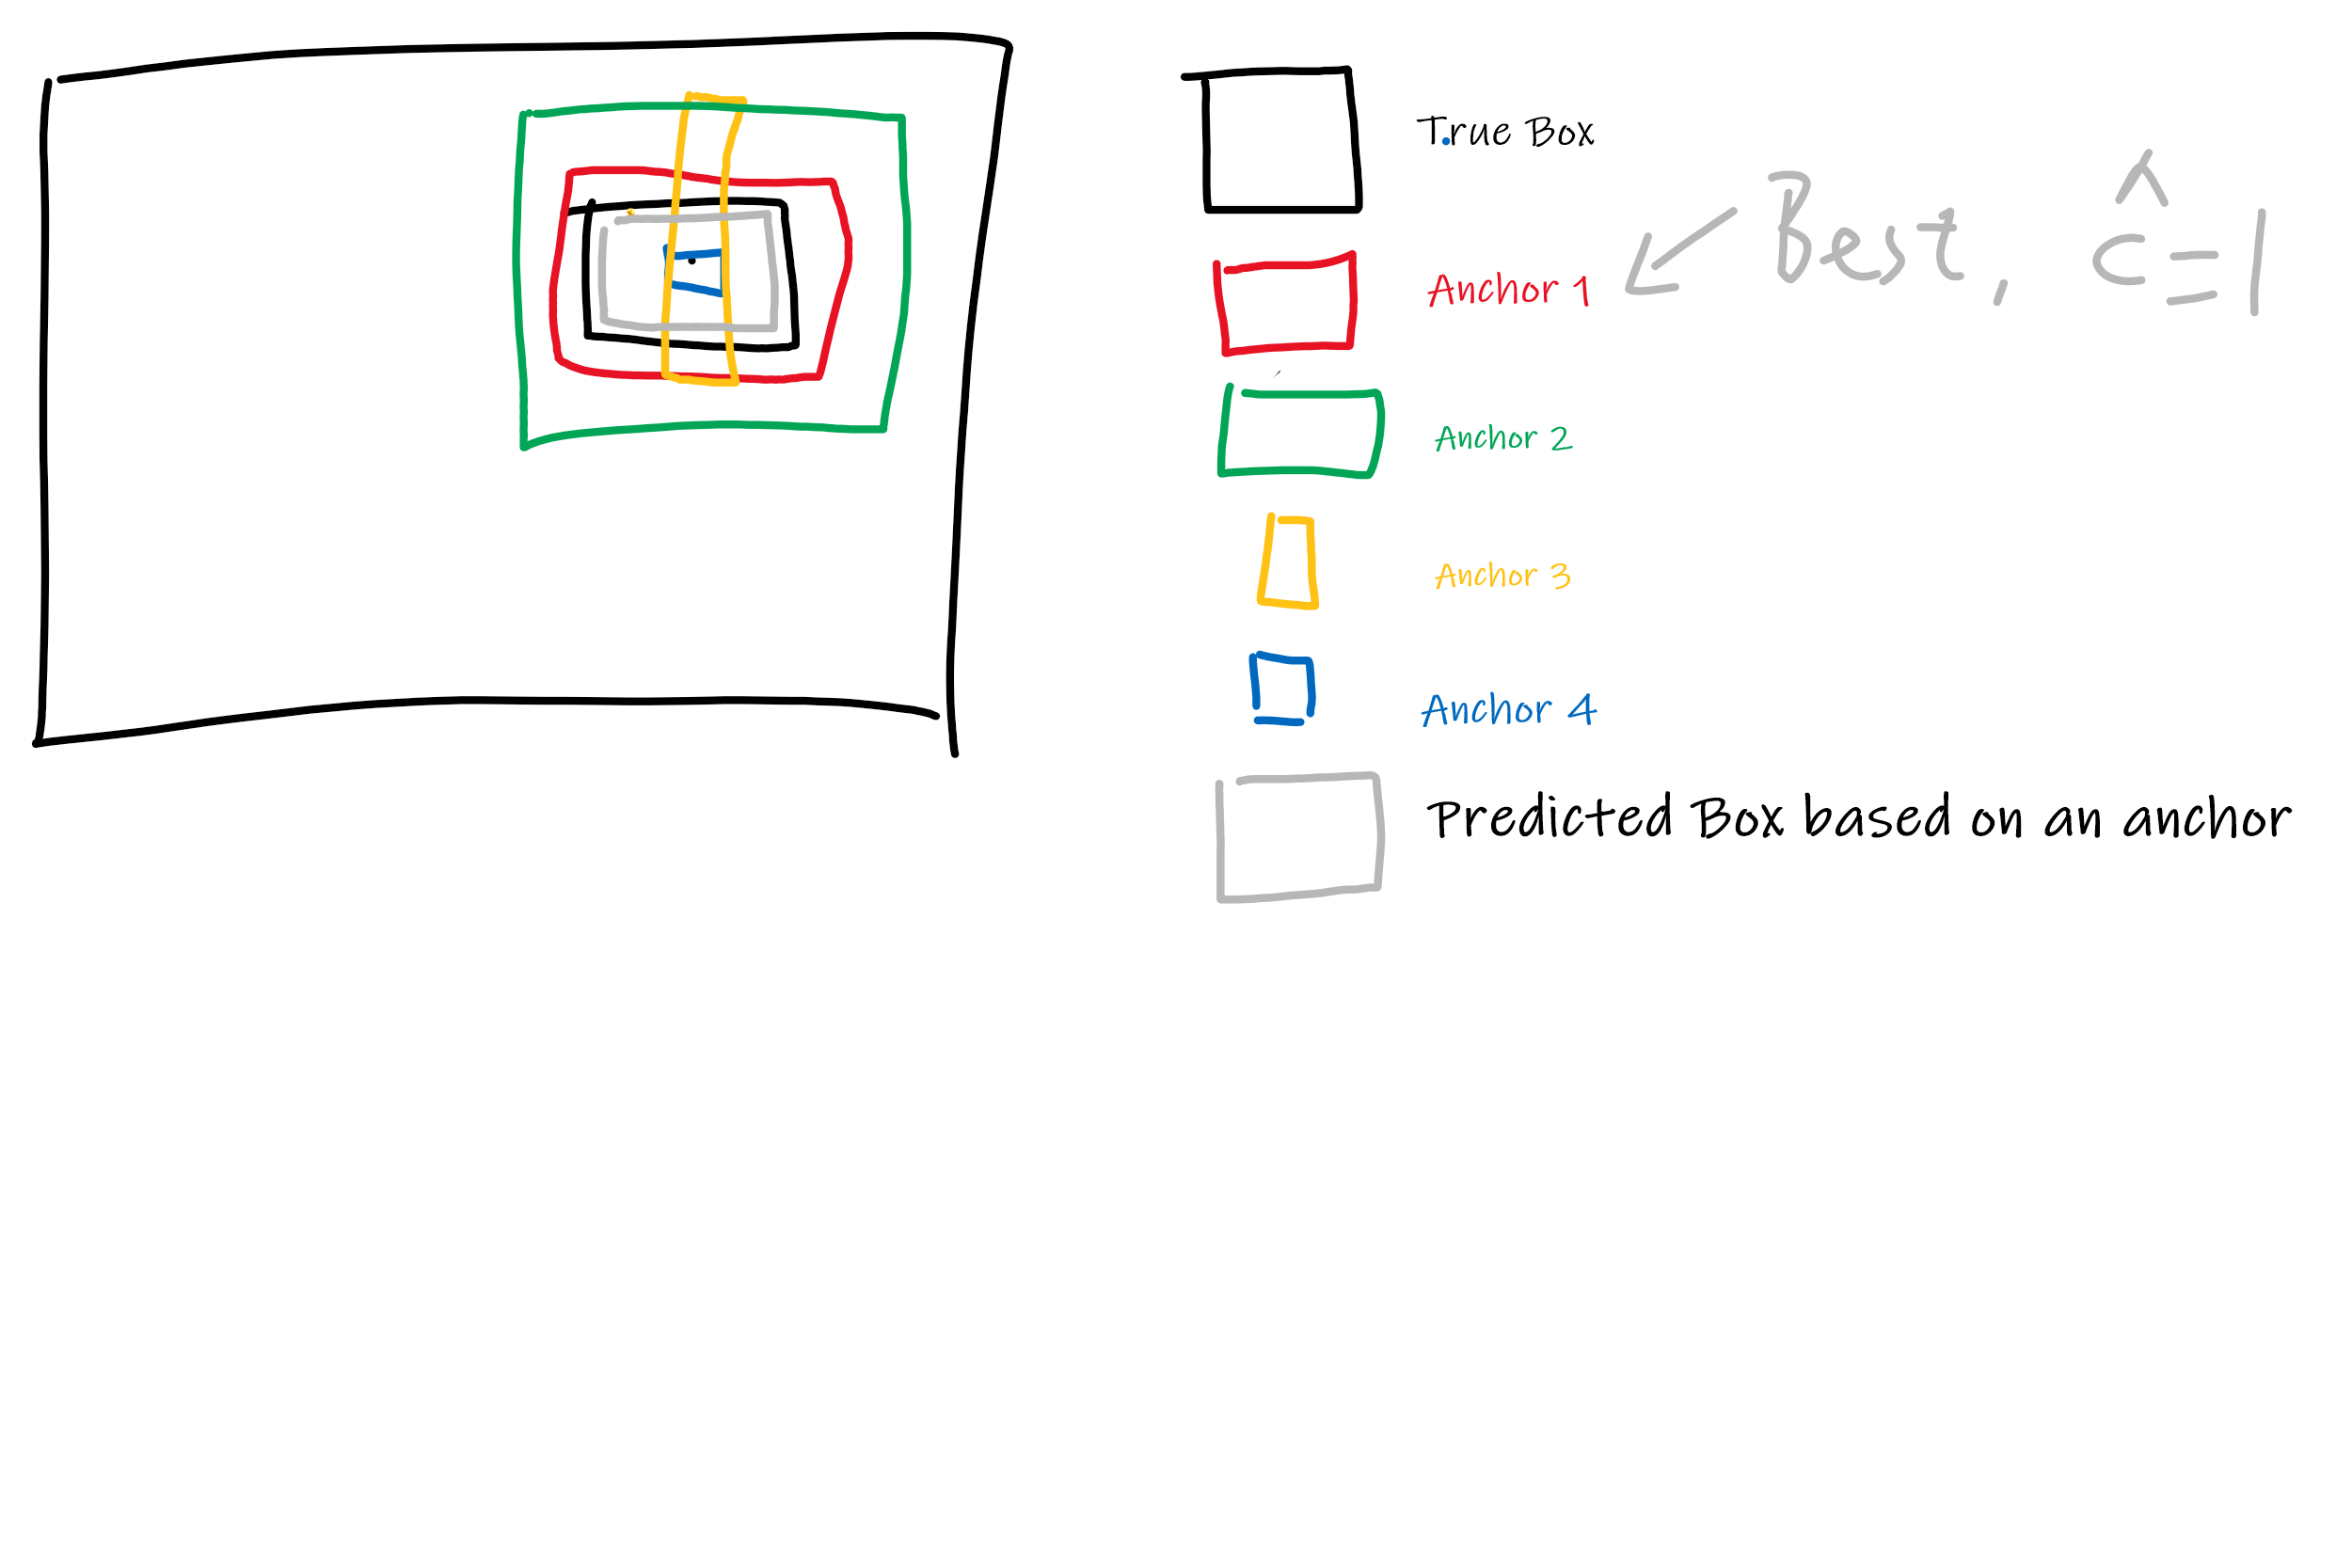

In [ ]:
# it is defined by tensorflow and very fragile 
def custom_loss(y_true, y_pred):
    # size of y: [N, 13, 13, 5, 4+1+NUM_class]
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    '''
        calculate meshgrid
    '''
    mask_shape = tf.shape(y_true)[:4]
    # mask_shape=[N_batch, 13,13, 5]
    
    # X, Y meshgrid, coordinate of each grid
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)),'float32')
    cell_y = tf.compat.v1.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.compat.v1.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)

    '''
        get slice of predicted [X Y], predicted [W H], confidence, and class
    '''
    ### adjust x and y, normalize each x and y centered with the coor of each grid 
    pred_box_xy = tf.math.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h, get the normalized w and h of the box
    pred_box_wh = tf.math.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence, whether there is an object(1) or not(0) for each box of each grid
    pred_box_conf = tf.math.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities, what kind of the object
    pred_box_class = y_pred[..., 5:]
    
    '''
        Adjust ground truth, do same thing on our label
    '''
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    '''
        get boxes information (left bottom point and right upper point) to calculate IOU
    '''
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half # left bottom of a box
    true_maxes   = true_box_xy + true_wh_half  # right upper of a box
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    # calulate intersection of union
    intersect_mins  = tf.math.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.math.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.math.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.math.truediv(intersect_areas, union_areas)
    # when there is an object(1) true_box_conf = iou_scores else: true_box_conf=0
    true_box_conf = iou_scores * y_true[..., 4]
    

    ### adjust class probabilities
    true_box_class = tf.math.argmax(y_true[..., 5:], -1)
    
    '''
        Determine the masks
    '''
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2] # size[1, 1, 1, B, 2]
    true_wh = true_boxes[..., 2:4] # size[1, 1, 1, B, 2]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # size[1, 1, 1, B, 1, 2]
    pred_wh = tf.expand_dims(pred_box_wh, 4) # size[1, 1, 1, B, 1, 2]
    
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half # # size[N, H, W, B, 2]
    pred_maxes   = pred_xy + pred_wh_half    
    
    
    intersect_mins  = tf.math.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.math.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.math.maximum(intersect_maxes - intersect_mins, 0.) # must have some overlap, otherwise 0
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1] # size[N, H, W, B, 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.math.truediv(intersect_areas, union_areas) # size[N, H, W, B, 1]
    
    best_ious = tf.math.reduce_max(iou_scores, axis=4) # size[N, H, W, B]
    conf_mask = conf_mask + tf.cast(best_ious < 0.6, 'float32') * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.cast(coord_mask < COORD_SCALE/2.,'float32')
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.math.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.math.reduce_sum(tf.compat.v1.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.math.reduce_sum(tf.compat.v1.to_float(conf_mask  > 0.0))
    nb_class_box = tf.math.reduce_sum(tf.compat.v1.to_float(class_mask > 0.0))
    
    loss_xy    = tf.math.reduce_sum(tf.math.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.math.reduce_sum(tf.math.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.math.reduce_sum(tf.math.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.math.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.math.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.math.reduce_sum(tf.cast(true_box_conf > 0.5,'float32') * tf.cast(pred_box_conf > 0.3,'float32'))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.compat.v1.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

## Train the model

---

In [ ]:
# Define a configuration
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}
def normalize(image):
    return image / 255.

In [ ]:

# Get 
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('train_imgs', 'wb') as fp:
#    pickle.dump(train_imgs, fp)

### read saved pickle of parsed annotations
#with open ('train_imgs', 'rb') as fp:
#    train_imgs = pickle.load(fp)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('valid_imgs', 'wb') as fp:
#    pickle.dump(valid_imgs, fp)

### read saved pickle of parsed annotations
#with open ('valid_imgs', 'rb') as fp:
#    valid_imgs = pickle.load(fp)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

In [ ]:
# Fit
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)
tensorboard = TensorBoard(log_dir='./logs', 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)
model.fit_generator(generator = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

(?, 1, 1, 1, 50, 2)
(16, 13, 13, 5, 1, 2)
(16, 13, 13, 5, 50, 2)
(16, 13, 13, 5, 50)
(16, 13, 13, 5)
Epoch 1/100


KeyboardInterrupt: ignored

## Detect Objects

In [ ]:
model.load_weights('weights.h5')
#image = cv2.imread('/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00001.jpg')
image = cv2.imread('1.png')
#image = cv2.imread('/content/license-plate-dataset/dataset/valid/images/dayride_type1_001.mp4#t=1135.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))
input_image = cv2.resize(image, (416,416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.2,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [ ]:
! cp weights.h5 drive/My\ Drive/weights_bccd.h5

In [ ]:

assert 1==2
# do not run this cell, it is used to show how we get the final boxes from yolo network output.
def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    # shape of netout: [grid_h, grid_w, nb_box, x+y+w+h+obj+classes*n]
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    ## decode the obj and possibility of different class.
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    # 
    # for each box of each grid, get its class, confidence, and object box information
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # remove the boxes overlapped with another box which belongs to same class but has bigger possibility
    # It means, we only choose the box which has biggest possibility for an object 
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0           
    
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    
